<a href="https://colab.research.google.com/github/choprahetarth/background-remover/blob/main/Background_Removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Notebook has been created for removing backgrounds fron images, using primarily two methods


1.   Deep Learning (Facebook's Detectron2 Pre-Trained Models)
2.   Classical Computer Vision (Experimental)

## Instructions for using `Deep Learning` based solution - 

1. Switch to a GPU Runtime offered by Google Colab (Runtime-> Change Runtime Type -> GPU )
2. Install the libraries by running the `Install (Run Once) (USE GPU RUNTIME)` Tab
3. The runtime **WILL Crash**, let it ,as it is required to restart the runtime.
4. Expand the `Import Libraries and Upload Images` Tab
5. Upload the foreground and background images as prompted by the cell which is running, and let it upload.
6. Expand the `Approach 1 - Detectron2` Tab
7. Expand the `Input Area - Play with these parameters`, and edit the parameters accordingly. For a good baseline to start working with tick the `USE_DEFAULT` check-box and run the cell.
8. Run all the cells within the `Functions` Tab, no need to open.
9. Expand the Display and run all cells. Enjoy the output.

## Instructions for using `Classical CV` based solution - 
1. Restart the Runtime `Ctrl+M` and repeat step 2
2. Repeat Steps 4 and 5
3. Expand the `Approach 2 - Classical CV (Experimental)` Tab
4. Repeat Step 7, but for the current expanded Tab.
5. Repeat Step 8, but for the current expanded Tab.
6. Repeat Step 9, but for the current expanded Tab.

## Theoretical Concepts and Code Inspirations - 
For Deeep Learning Based solution - 
1. https://ai.facebook.com/blog/-detectron2-a-pytorch-based-modular-object-detection-library-/
2. https://github.com/facebookresearch/detectron2
3. https://www.jeremyjordan.me/semantic-segmentation/

For the Computer Vision Based Solution - 
1. https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html#:~:text=Contours%20can%20be%20explained%20simply,and%20object%20detection%20and%20recognition.&text=In%20OpenCV%2C%20finding%20contours%20is,white%20object%20from%20black%20background.
2. https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html
3. https://radiant-brushlands-42789.herokuapp.com/towardsdatascience.com/background-removal-with-python-b61671d1508a
4. https://pillow.readthedocs.io/en/stable/reference/PixelAccess.html


## About the Parameters in Deep Learning Method- 
1. `YAML` - This contains a plethora of models pre-trained on the `COCO` dataset - https://cocodataset.org/#home
- To know more about these models and their metrics - https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
- TLDR - We have included both instance and panoptic segmentation

## About the Parameters in Classical CV Approach- 
1. `Blur` - This provides the kernel size of the gaussian blur that you want to use in order to *smoothen* out the prediction mask.
2. `Erode Iter` - This is used as a morphological transformation method, in order to *sharpen* out the mask acquired.
3. `Dilate Iter` - This is used as a morphological transformation method, in order to *expand* out the mask acquired.
4. `Min Area` and `Max Area` - As per the edges detected, it is used to specify the minimum area and the maximum area of the them, so as to transform them into contours after filling them.



# Install (Run Once) (USE GPU RUNTIME)

In [1]:
!pip install pyyaml==5.1 > /dev/null
# This is the current pytorch version on Colab. 
# Uncomment this if Colab changes its pytorch version
# !pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html > /dev/null
exit(0)  # After installation, 
#you need to "restart runtime" in Colab. 
#This line can also restart runtime

# Import Libraries and Upload Images


In [1]:
# Import all the libraries
import numpy as np
import cv2
import requests
import os
import imutils
from PIL import Image
from google.colab.patches import cv2_imshow

In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import torch, torchvision
import json, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
## Upload your Foreground Image
print("Upload your Foreground Image: ")
from google.colab import files
uploaded = files.upload()

Upload your Foreground Image: 


Saving 08.jpeg to 08.jpeg


In [4]:
foreground = str(list(uploaded.keys())[0])

In [5]:
## Upload your Background Image
print("Upload your Foreground Image: ")
from google.colab import files
uploaded = files.upload()

Upload your Foreground Image: 


Saving background.jpeg to background.jpeg


In [6]:
background = str(list(uploaded.keys())[0])

# Approach 1 - Detectron2

## Input Area - Play with these parameters
In case you want a good ballpark 


1.   BG_COLOR = (255,255,255)
2.   RESIZE = 500
3.  YAML = "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"


In [42]:
#@title Input Parameters (Do Run After changing params)
USE_DEFAULT = False #@param {type:"boolean"}
BACKGROUND = "Background_Image" #@param ["Background_Image", "Color"]
BG_COLOR = (255,0,255) #@param {type:"raw"}
RESIZE = 800 #@param {type:"raw"}
YAML = "COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml" #@param ["COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml","COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml","COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml","COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x.yaml","COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml","COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml","COCO-InstanceSegmentation/mask_rcnn_R_101_DC5_3x.yaml"]

if USE_DEFAULT:
  BG_COLOR = (255,255,255)
  BACKGROUND = "Color"
  RESIZE = 500
  YAML = "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"

## Functions 

In [43]:
# Streamlined Code
def read_image(image,bg,size):
  bg = bg
  image = image
  foreground = cv2.imread(image)
  background = cv2.imread(bg)
  foreground = imutils.resize(foreground, width=size)
  background = imutils.resize(background, width=size)

  return foreground,background

In [44]:
def config(image):
  image = image
  cfg = get_cfg()
  # add project-specific config (e.g., TensorMask) 
  # here if you're not running a model in detectron2's core library
  cfg.merge_from_file(model_zoo.get_config_file(YAML))
  # set threshold for this model
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  
  # Find a model from detectron2's model zoo. 
  # You can use the https://dl.fbaipublicfiles... url as well
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(YAML)
  predictor = DefaultPredictor(cfg)
  outputs = predictor(image)
  return outputs,cfg

In [45]:
def mask_blend(outputs):
  outputs = outputs
  mask = outputs["instances"].pred_masks
  # Mask Blender
  total_objects = mask.shape[0]
  # Considering logic that if objects > 1, take top two 
  masks = []
  if (total_objects > 1):
    for i in [0,1]:
      output_mat = outputs['instances'].pred_masks[i].cpu().detach().numpy()
      output_mat = output_mat.astype(np.uint8)
      output_mat = output_mat*255
      masks.append(output_mat)
    mask = cv2.bitwise_or(masks[0],masks[1])
  else:
    output_mat = outputs['instances'].pred_masks[i].cpu().detach().numpy()
    output_mat = output_mat.astype(np.uint8)
    output_mat = output_mat*255
    mask = output_mat
  return mask


In [46]:
def background_replace(image,mask,background_image):
  background_image = background_image
  image = image
  mask = mask
  masked = cv2.bitwise_and(image,image,mask = mask)
  replaced = np.copy(masked)
  if (BACKGROUND == "Color"):
    replaced[mask==0] = BG_COLOR
  elif (BACKGROUND == "Background_Image"):
    masked = Image.fromarray(cv2.cvtColor(masked,
                                          cv2.COLOR_BGR2RGB))
    #masked = Image.fromarray(masked)
    masked = masked.convert("RGBA")
    pixdata = masked.load()
    width, height = masked.size
    for y in range(height):
      for x in range(width):
        if pixdata[x, y] == (0, 0, 0, 255):
            pixdata[x, y] = (255, 255, 255, 0)

    background_image = cv2.resize(background_image,
                                  (image.shape[1],
                                   image.shape[0]))
    background_image = Image.fromarray(cv2.cvtColor(background_image,
                                                    cv2.COLOR_BGR2RGB))
    background_image.paste(masked, (0, 0), masked)
    replaced = background_image
  return replaced

In [47]:
def runner():
  image,bg_image = read_image(foreground,background,RESIZE)
  outputs,cfg = config(image)
  mask = mask_blend(outputs)
  final = background_replace(image,mask,bg_image)
  return final,bg_image,mask,image 
final,bg_image,mask,image = runner()

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


## Display

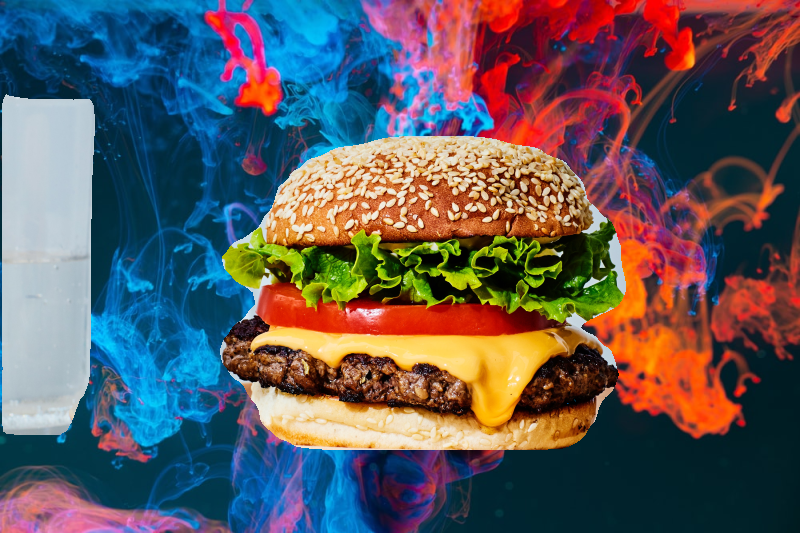

In [48]:
if (BACKGROUND == "Color") :
  cv2_imshow(final)
else :
  display(final)

Original Image: 


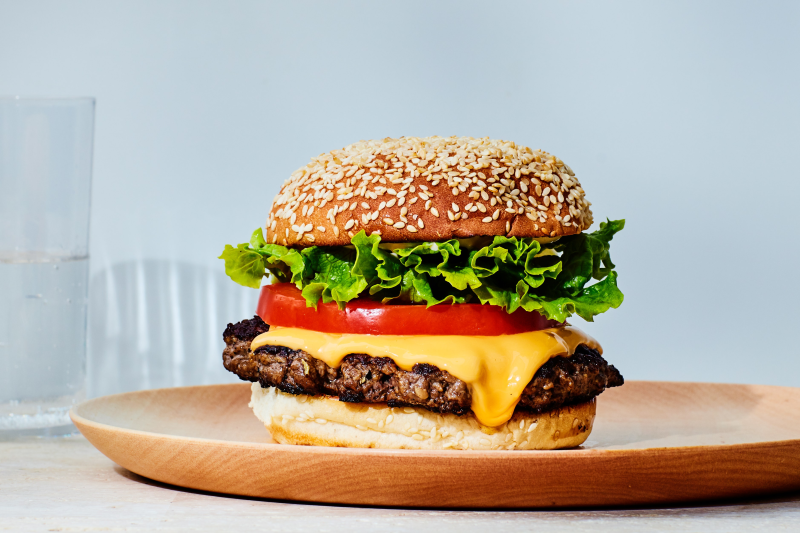

Background Image 


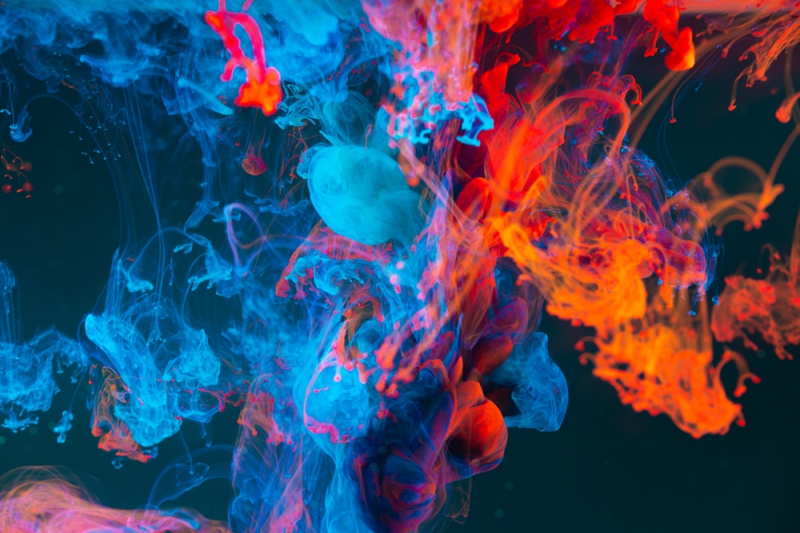

Mask


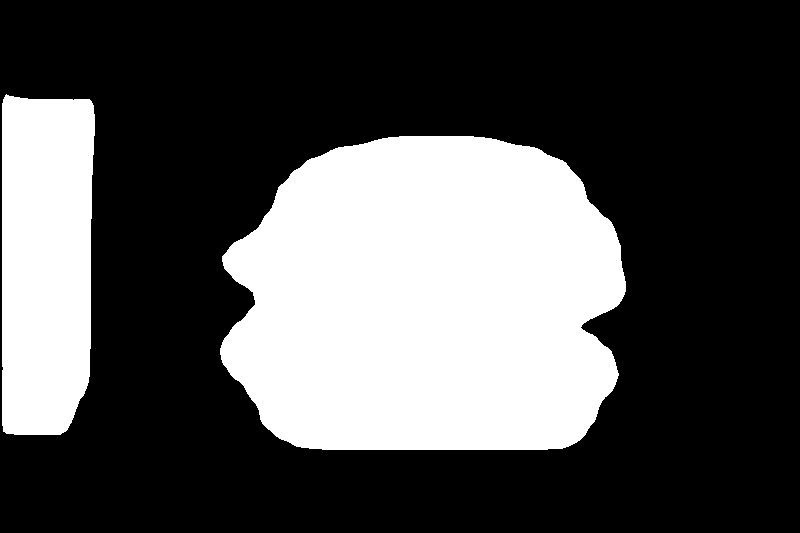

In [49]:
print("Original Image: ")
cv2_imshow(image)
print("Background Image ")
cv2_imshow(bg_image)
print("Mask")
cv2_imshow(mask)

# Approach 2 - Classical CV (Experimental)

## Input Area - Play with these parameters
This approach is more of an experimental one, intended to not be the baseline, but as a method to understand more about these parameters.

In case you want a good ballpark 


1.   BG_COLOR = (255,255,255)
2.   BLUR = 3
3.   CANNY_LOW = 15
4.   CANNY_HIGH = 150
5.   MIN_AREA = 0.0005
6.   MAX_AREA = 0.95
7.   DILATE_ITER = 3
8.   ERODE_ITER = 3
9.   RESIZE = 500


  




In [239]:
#@title Input Parameters (Do Run After changing params)
USE_DEFAULT = False #@param {type:"boolean"}
BACKGROUND = "Background_Image" #@param ["Background_Image", "Color"]
BG_COLOR = (255,0,255) #@param {type:"raw"}
BLUR = 1 #@param [1,3,5,7,11,19,21] {type:"raw"}
CANNY_LOW = 20 #@param {type:"slider", min:1, max:40, step: 1}
CANNY_HIGH = 150 #@param{type:"slider", min:100, max:200, step:1}
MIN_AREA = 0.013 #@param{type:"slider", min:0.0001, max:0.1, step:0.0001}
MAX_AREA = 0.5 #@param{type:"slider", min:0.05, max:0.99, step:0.01}
DILATE_ITER = 1 #@param [1,3,5,7,11,19,21] {type:"raw"}
ERODE_ITER = 1 #@param [1,3,5,7,11,19,21] {type:"raw"}
RESIZE = 500 #@param {type:"raw"}

if USE_DEFAULT:
  BG_COLOR = (255,255,255)
  BACKGROUND = "Background_Image"
  BLUR = 3
  CANNY_LOW = 15
  CANNY_HIGH = 150
  MIN_AREA = 0.0005
  MAX_AREA = 0.95
  DILATE_ITER = 3
  ERODE_ITER = 3
  RESIZE = 500

## Functions (Run-All)

In [240]:
# StreamLined Code
def read_image(image,bg,size):
  bg = bg
  image = image
  foreground = cv2.imread(image)
  background = cv2.imread(bg)
  foreground = imutils.resize(foreground, width=size)
  background = imutils.resize(background, width=size)

  return foreground,background

In [241]:
def preprocess(image):
  # convert the image to greyscale
  grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # detect lines and edges using canny
  edges = cv2.Canny(grey, CANNY_LOW, CANNY_HIGH)
  # dilate and erode the edges
  edges = cv2.dilate(edges,None) 
  edges = cv2.erode(edges,None)
  return edges

In [242]:
def masking(edges):
  edge = edges
  # get the contours and their areas
  contour_info = [(c, cv2.contourArea(c),_) for c in 
                  cv2.findContours(edge,
                                   cv2.RETR_LIST,
                                   cv2.CHAIN_APPROX_NONE)[0]]
  # Set up mask with a matrix of 0's
  mask = np.zeros(edge.shape, dtype = np.uint8)

  # Get the area of the image as a comparison
  image_area = edge.shape[0] * edge.shape[1]  

  # calculate max and min areas in terms of pixels
  max_area = MAX_AREA * image_area
  min_area = MIN_AREA * image_area

  # Go through and find relevant contours and apply to mask
  for contour in contour_info:
  #  Instead of worrying about all the smaller contours,
  # if the area is smaller than the min, the loop will break
    if contour[1] > min_area and contour[1] < max_area:
      # Add contour to mask
      mask = cv2.fillConvexPoly(mask, contour[0], (255))
  # use dilate, erode, and blur to smooth out the mask
    mask = cv2.dilate(mask, None, iterations=DILATE_ITER)
    mask = cv2.erode(mask, None, iterations=ERODE_ITER)
    mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
  return mask

In [243]:
def background_replace(image,mask,background_image):
  background_image = background_image
  image = image
  mask = mask
  masked = cv2.bitwise_and(image,image,mask = mask)
  replaced = np.copy(masked)
  if (BACKGROUND == "Color"):
    replaced[mask==0] = BG_COLOR
  elif (BACKGROUND == "Background_Image"):
    masked = Image.fromarray(cv2.cvtColor(masked,
                                          cv2.COLOR_BGR2RGB))
    #masked = Image.fromarray(masked)
    masked = masked.convert("RGBA")
    pixdata = masked.load()
    width, height = masked.size
    for y in range(height):
      for x in range(width):
        if pixdata[x, y] == (0, 0, 0, 255):
            pixdata[x, y] = (255, 255, 255, 0)

    background_image = cv2.resize(background_image,
                                  (image.shape[1],
                                   image.shape[0]))
    background_image = Image.fromarray(cv2.cvtColor(background_image,
                                                    cv2.COLOR_BGR2RGB))
    background_image.paste(masked, (0, 0), masked)
    replaced = background_image
  return replaced

In [244]:
image,bg_image = read_image(foreground,background,RESIZE)
edges = preprocess(image)
mask = masking(edges)
final = background_replace(image,mask,bg_image)

## Output Area 

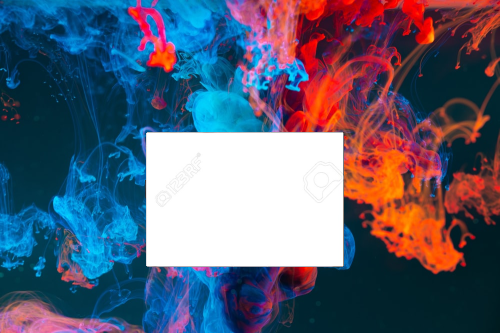

In [245]:
if (BACKGROUND == "Color") :
  cv2_imshow(final)
else :
  display(final)

Original Image: 


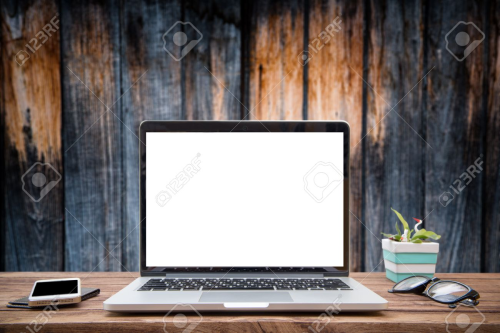

Background Image: 


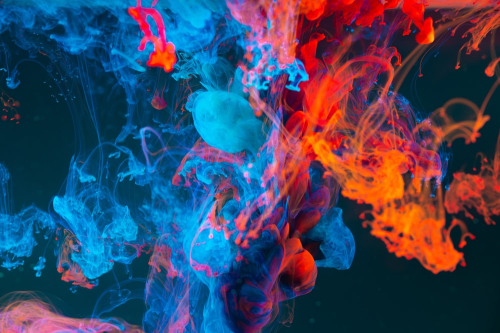

Extracted Edges: 


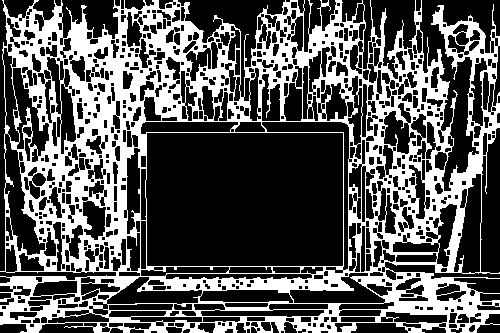

Contour Mask: 


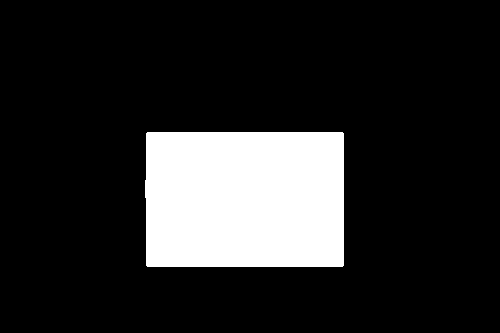

In [246]:
print("Original Image: ")
cv2_imshow(image)
print("Background Image: ")
cv2_imshow(bg_image)
print("Extracted Edges: ")
cv2_imshow(edges)
print("Contour Mask: ")
cv2_imshow(mask)